In [ ]:
from bipeddemo import BipedEnv
import os
import numpy as np
from stable_baselines3 import PPO
import time
import animatebiped
import gait_generator

print('All packages are installed and working.')

In [ ]:
desired_speed = 2.0
model = PPO.load("/home/baran/Bipedal-imitation-rl/model_checkpoint_400000_steps.zip")
env = BipedEnv(desired_speed=desired_speed)

0


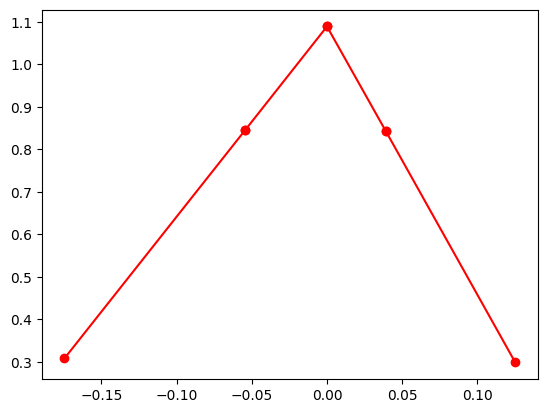

1


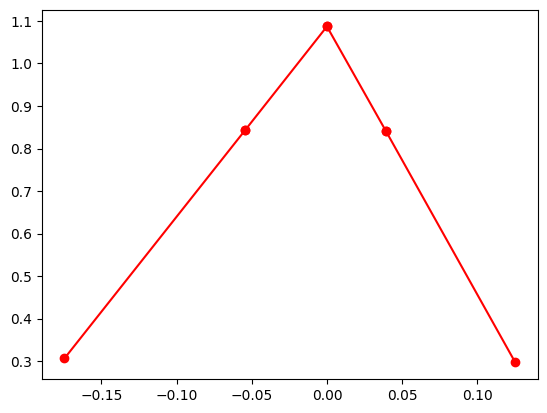

2


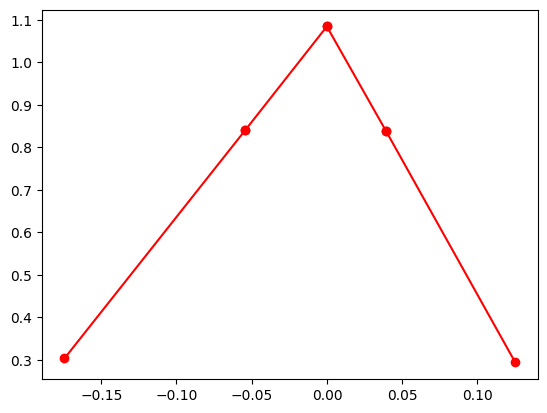

3


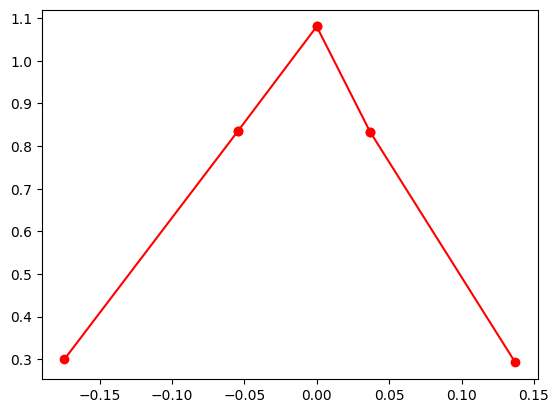

4


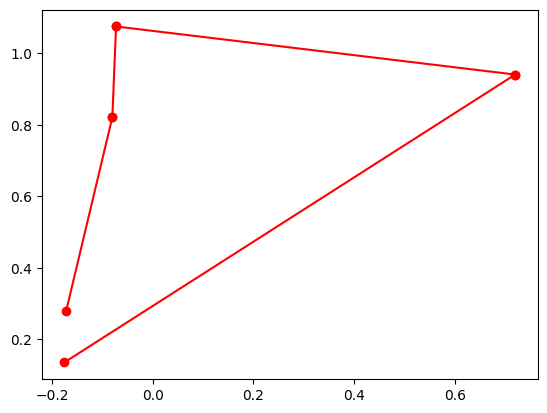

5


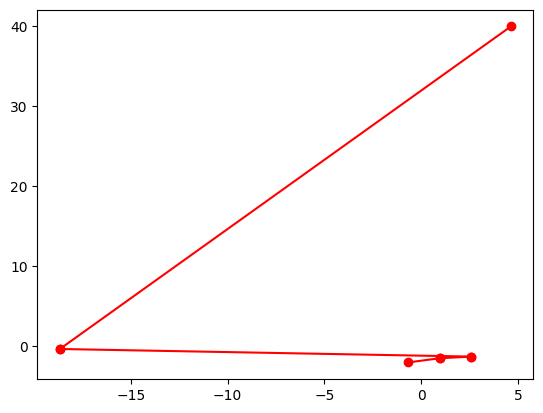

6


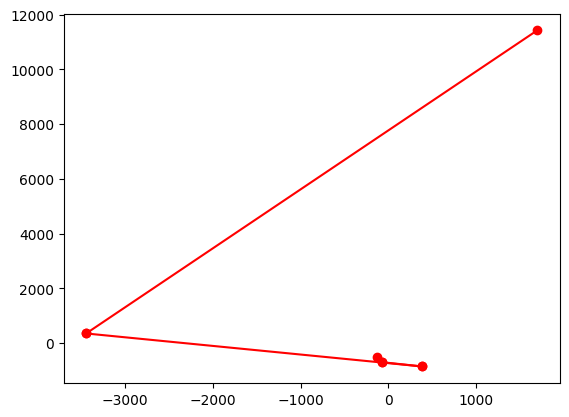

7


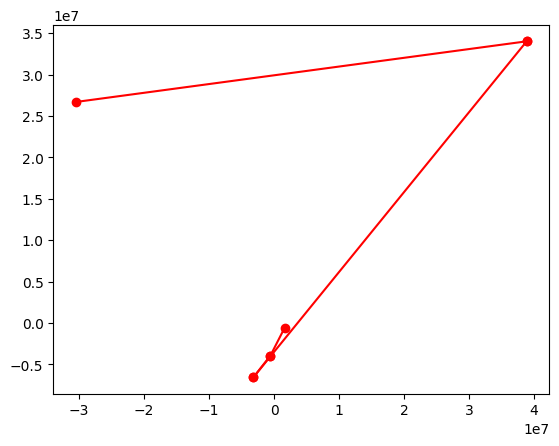

8


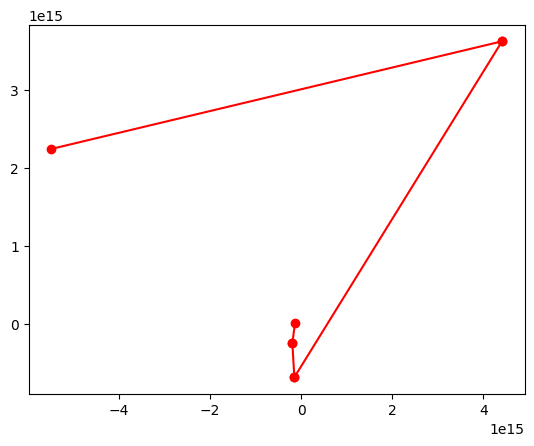

9


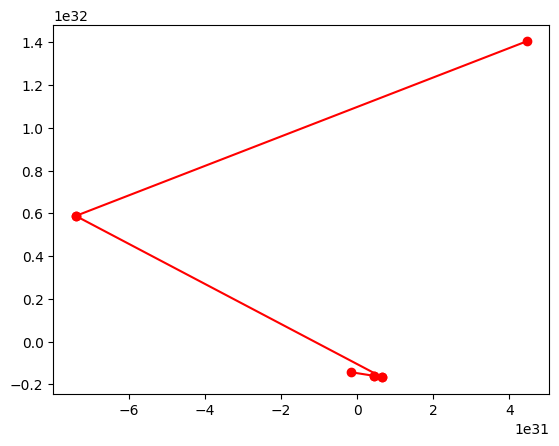

10


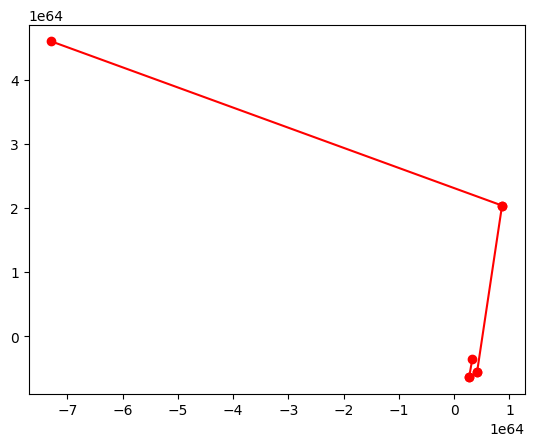

11


ValueError: Expected parameter loc (Tensor of shape (1, 6)) of distribution Normal(loc: torch.Size([1, 6]), scale: torch.Size([1, 6])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan]], device='cuda:0')

In [10]:
import matplotlib.pyplot as plt
obs, info = env.reset()  # Gym API
angle_array = np.empty((0,4))
for i in range(0, 200):
    print(i)
    action, _states = model.predict(obs)
    obs, rewards, dones, truncated, info = env.step(action)
    states = obs[2:16]
    # print(obs[:2])
    # angles = np.pi/2 - states[[4,10,7,13]]
    # angles[1] = angles[1] - angles[0]
    # angles[3] = angles[3] - angles[2]
    # angle_array = np.vstack((angle_array, angles))
    hip_x = states[0]
    hip_y = states[1]
    r_u_leg_x = states[2]
    r_u_leg_y = states[3]
    l_u_leg_x = states[5]
    l_u_leg_y = states[6]
    r_l_leg_x = states[8]
    r_l_leg_y = states[9]
    l_l_leg_x = states[11]
    l_l_leg_y = states[12]
    plt.figure(1)
    plt.plot([hip_x, r_u_leg_x], [hip_y, r_u_leg_y], 'ro-')
    plt.plot([hip_x, l_u_leg_x], [hip_y, l_u_leg_y], 'ro-')
    plt.plot([r_u_leg_x, r_l_leg_x], [r_u_leg_y, r_l_leg_y], 'ro-')
    plt.plot([l_u_leg_x, l_l_leg_x], [l_u_leg_y, l_l_leg_y], 'ro-')
    plt.show()

In [7]:
obs

array([ 0.00000000e+00,  2.00000000e+00, -4.97243926e+59, -3.21192201e+59,
        1.11780478e+60,  1.93530063e+58, -2.26561414e+60, -4.18887342e+59,
       -8.29664750e+58, -1.00252316e+60,  4.83067825e+60,  3.80418148e+60,
        3.88763098e+60, -8.68566480e+58,  1.61448502e+59, -8.45786821e+59,
       -4.97243926e+61, -3.21192201e+61,  1.11780478e+62,  1.93530063e+60,
       -2.26561414e+62, -4.18887342e+61, -8.29664750e+60, -1.00252316e+62,
        4.83067825e+62,  3.80418148e+62,  3.88763098e+62, -8.68566480e+60,
        1.61448502e+61, -8.45786821e+61])

In [ ]:
animatebiped.animate_biped(angle_array, 'demo.gif')